<a href="https://colab.research.google.com/github/alexandra1249/NEUS642_20200204/blob/master/Auditory%20Encoding%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Making an STRF**

## **Introduction**
When a neuron in the auditory cortex receives information about a sound that's passed through early auditory areas, how does that neuron transofrm and represent that sound? A spectro temporal receptive field (STRF) is a model that describes neural function as a filter that can be used to predict neural outputs given a stimulus. An STRF describes spectral and temporal aspects of a stimulus spectrogram that will lead to a stronger neural response. 

The data we will be looking at today is from single-unit recordings from the primary auditory cortex of *Mustela putorius*, or ferrets.

<br><img src="Ferret.png"/>
<br> A ferret bathing in the wild

To stimulate neurons in A1, several TORCs (temporaly orthognal ripple combinations) are played. TORCs differ in phase from one another but are composed of the same total frequency and are noise-like stimuli constructed to sample spectro-temporal stimulus space efficiently. Response data comes in the form of a peri-stimulus time histogram (PSTH) or a histogram of the time when neurons fire.

The objective of todays lesson is to take this data and transform it into a format whereby an STRF can be calculated. We will also plot an an easy to read and visually appealing STRF.

## **Objectives**
The goal of this exercise is to take stimulus and response data and generate a model of auditory encoding.
<br><img src="cool_colors.png"/>


<a name="#Used-in-today's-class"></a>
### **Used in today's class**

### Dictionary methods
* `dict.keys()` - returns list of available keys
* `dict.values()` - returns list of available values
* `dict.fromkeys()` - takes two parameters, (sequence[,value]) where setting the value of each element of the dictionary is optional.It returns a new dictionary with the sequence of elements as the keys;
* `dict.items()` - returns list of key,value tuple pairs

### Numpy
* `np.swapaxes()`- interchanges two axes of an array
* `np.stack()`- joins a sequence of arrays along a new axis
* `np.unique()`- finds the unique elements of an array
* `np.flip()`- flips the order of elements in an array along the axis
* `np.max()`- compares two arrays and returns a new array with the element maximum
* `np.roll()`- rolls array down along an axis, any elements that roll down the end of the axis end up at the beginning of the axis
* `np.concatenate()`- join arrays along a given axis
* `np.expand_dims()`- expand a new array by inserting a new axis at a specificed position
* `np.dot()`- When both arrays are 2D (which they are here) it is the dot product of two arrays through matrix multiplication
* `np.linalg.pinv()`- finds the generalized inverse of a matrix
* `np.reshape()`- gives a new shape to the array without effecting the data
* `np.log2()`- base-2 logarithm
* `np.mean()`- returns the mean of a specified axis

### Plotting
* `plt.imshow()` - display an image
* `plt.yticks()`- list of positions where ticks should be added and optional labels
* `plt.ylabel()`- text for the y axis
* `plt.xlabel()`- text for the x axis
* `plt.title()`- text for the title

### Other
* `append()`- adds a single item to the end of the list
* `enumerate()`- adds counter to iterable in a `for` loop
* `format()`- allows string value formatting and substitutions, also lets you positionally concatenate in elements








## **Loading the Data**
Let's import some modules we'll be using throughout the lesson. First we'll import our olds friends `Numpy` and `matplotlib` then some newer ones like `pickle`. Also, we're going to import a few pre-made functions from code we already wrote to save some time, we'll give you a heads up when you need to call them and what they do when the time comes. (I'm also slipping `fs=1000` in there, that's just our sampling frequency and we'll need it for some things down the road)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
%matplotlib inline
fs=1000
#import functions, we need to make a new page for that

Normally when trying to analyze auditory stimulus and response date we would have to load recording files in a way where we must manually extract the data by calling on functions that search segments of the data in time called epochs and select only those where a stimulus is being played. Today though we will be using data where we have pickled the stimulus and response data for you, which is also going to be a fun exercise. The data you will get is two dictionaries, basically the stimulus data which will be called exptparams and the response data r.

## **What the heck are pickles?**

<br><img src="PortlandPicklesLogo.png"/>

Pickling allows for python objects, such as a list or dictionary to be converted to binary. Unpickling brings it back.
This can be useful for several reasons:

1) saving a program's state data to disk so that it can carry on where it left off when restarted (persistence)

2) sending python data over a TCP connection in a multi-core or distributed system (marshalling)

3) storing python objects in a database

4) converting an arbitrary python object to a string so that it can be used as a dictionary key (e.g. for caching & memoization).
(https://pythontips.com/2013/08/02/what-is-pickle-in-python/)

Side note: Pickles can easily be hacked and have malicious code in there that will run when you de-pickle it. So make sure you trust any pickles that are sent to you. You can of course trust the pickles that we had you download before class... We wouldn't put malicious code in that sent us your mother's maiden name, the name of your first pet, and the last four of your SNN. That's ridiculous. Why would you even ask that?


So, let's unpickle! First, we need to find our pickles though. Let's do some pathfinding to locate them (this part will look familiar). They're in the notebook that you opened to get here, so you will just need to type `Pickle` into the prompt.

In [0]:
folder_path = input('Enter the path to the folder: ')

Okay, you now have a variable that is the path to the pickles, let's make a list of all the files within the folder we found.

In [0]:
folder_list = list(Path(folder_path).iterdir())
folder_list

NameError: ignored

So we only have two files here, but imagine you had more, let's say 20 pickles and 10 pictures of your dog. Right now, we don't care about your dog so let's take only the `.pkl` files.

In [0]:
pickle_list = [fn for fn in folder_list if fn.suffix == '.pkl']
pickle_list

Now, `pickle_list` is a list that contains the filenames we will want to import, right now it's two, but let's use a `for` loop so that no matter how many files we have in our list, we can load them all into a single dictionary.

`for` loops have three basic components, the variable, the iterable, and the statements.  The formatting is normally as follows:

```
for <variable> in <iterable>:
   <statement(s)>
```

 There are many flavors of `for` loops that we will be working with. The above example is the vanilla flavor. It's delicious, it is a classic, but it could definitely have more flare.



In this instance, first we're going to make an empty dictionary which our `for` loop will populate. The next line will loop, saying that for each file in the list, it will temporarily assign it to the variable `pick`.
The third line says to open that file to a variable which gets passed to the `load` method. 

```
pickle_dict = dict()
for pick in folder_list:
    pkl_file = open(pick, 'rb')
```
The final line has you assign the name of the pickle file (without the `.pkl` extension) as a key (more on that soon) that will have the value of the loaded pickle file.

In [0]:
pickle_dict = dict()
for pick in folder_list:
    with open(pick, 'rb') as pkl_file:
        pickle_dict[pick.stem] = pickle.load(pkl_file)

Thank god we finally have all of that into a dictionary. For our next step we will now throw that dictionary in the garbage.

You may ask yourself, "But why? Why did we make a dictionary then?"
For only two pickles, honestly this is crazy over kill. But what if you were king of the pickles and had thousands of pickles?
The `for` loop above will allow you to open all of them with just a few lines of code and the indexing of the dictionary in the cell below allows you to grab just a bit of our new dictionary that you need as variables.

In [0]:
r = pickle_dict['r']
exptparams = pickle_dict['exptparams']

## **Working with the Data**
Cool, our pickles are now two dictionaries `r` and `exptparams`. Before we blindly charge ahead, let's get familiar with our dictionaries, starting with `r`, which contains the response data from the unit we recorded from. To help us get friendly with `r`, let's use some dictionary methods.

The nicest one *(subjective)* to use is `.keys()`, which will display out the keys in the dictionary. I just used the word in the definition, but basically, a dictionary is an associative data type that matches a `key` and a `value` where the key is the unique index for a given value.

In [0]:
r.keys()

dict_keys(['STIM_TORC_448_LIN_01_h501', 'STIM_TORC_448_LIN_02_h501', 'STIM_TORC_448_LIN_03_h501', 'STIM_TORC_448_LIN_04_h501', 'STIM_TORC_448_LIN_05_h501', 'STIM_TORC_448_LIN_06_h501', 'STIM_TORC_448_LIN_07_h501', 'STIM_TORC_448_LIN_08_h501', 'STIM_TORC_448_LIN_09_h501', 'STIM_TORC_448_LIN_10_h501', 'STIM_TORC_448_LIN_11_h501', 'STIM_TORC_448_LIN_12_h501', 'STIM_TORC_448_LIN_13_h501', 'STIM_TORC_448_LIN_14_h501', 'STIM_TORC_448_LIN_15_h501', 'STIM_TORC_448_LIN_16_h501', 'STIM_TORC_448_LIN_17_h501', 'STIM_TORC_448_LIN_18_h501', 'STIM_TORC_448_LIN_19_h501', 'STIM_TORC_448_LIN_20_h501', 'STIM_TORC_448_LIN_21_h501', 'STIM_TORC_448_LIN_22_h501', 'STIM_TORC_448_LIN_23_h501', 'STIM_TORC_448_LIN_24_h501', 'STIM_TORC_448_LIN_25_h501', 'STIM_TORC_448_LIN_26_h501', 'STIM_TORC_448_LIN_27_h501', 'STIM_TORC_448_LIN_28_h501', 'STIM_TORC_448_LIN_29_h501', 'STIM_TORC_448_LIN_30_h501'])

That's a long list of strings that seems to have no meaning! But, let's pause to notice some things in the chaos, namely that we told you earlier `r` is our response data, so these keys must be response data organized into what stimuli (a TORC) it is responding to, so that's where `STIM_TORC_` comes from. 

Also, the only thing different is a number that seems to be counting up, this must be referring to how many different stimuli we generated responses from. We could go and count how many they are, but let's use the `len()` function instead to see how many TORC stimuli we have:

In [0]:
len(r.keys())

30

We have 30 TORCs. Now you know a little bit more about the data you're working with from two super simple lines of code, you know what your dictionary contains and how many of them there are! Cool, but these are just names, what information is hiding in the dictionary? Let's find out. 

We could do this two ways, `dict.values()` will tell us the value associated with each key. I'll tell you, that will be tremendously long to look at in this case. Instead, let's index to look at a single TORC's response data and explore that one. 

First it's important to see what kind of data we're working with, for that we'll use the `type()` function (remember that we'll use dictionary indexing in the format of `dictionary['key']` to do that):

In [0]:
type(r['STIM_TORC_448_LIN_01_h501'])

numpy.ndarray

It's an array! What's something important to know about an array? You guessed it, it's its shape! We know how to do that with the `.shape` method:

In [0]:
r['STIM_TORC_448_LIN_01_h501'].shape

(10, 1, 1450)

It's a three-dimensional array. This is all good info, and I'll just tell you the first dimension is a count of repetitions of the stimuli and the last dimension is the length of the trial. We are going to get rid of the middle dimension in a second so don't worry about it.

## **Exercise**
So what do we have with `r`? We have response data from 30 TORC stimuli. It'd be nice if rather than a dictionary of the individual responses we had a single object of all the response information that could be manipulated at once. Let's work on that, with `for` loops!

You may be wondering, how do I turn a dictionary into a list into a new variable containing all the content, I'll start you off by creating an empty list for you:

In [0]:
torc_list = list()

`for` loop time!

 We're interested in the arrays in the dictionary, so how should we initiate our loop? Let's use `dict.values()` and call the variable `val`. In any given iteration of the loop, you've now loaded a `(10,1,1450)` array. Now we're going to take care of that extra dimension using the `np.squeeze()` function which will squeeze extra dimensions away, giving us a new array of dimensions `(10,1450)`! I'll tell you next that we don't want the array to look like this, we want time to be in the [0] dimension and repetitions in the [1] dimension. How do we *swap* the *axes* of our array? `np.swapaxes()` is how. Swapaxes takes three arguments, the array you're swapping, and then the axes over which you are swapping, of which we only have two, [0], and [1]. Assign this to a new variable `fval`.

Finally, let's use our `list.append()` method to add this new array `fval` we just made to the `torc_list` dictionary.

This will all be three lines of code, give nesting the functions `np.swapaxes` and `np.squeeze` a try so your code will look like `new_variable = np.swapaxes(np.squeeze(for_loop_variable),dim1,dim2)`. Notice how now the output of the squeeze, an array itself, is now already placed as the first argument of `np.swapaxes` because Python will work inside to out, pretty nifty! Give it a go:


In [0]:
# Answer
<for val in r.values():
    fval = np.swapaxes(np.squeeze(val), 0, 1)
    torc_list.append(fval)>

Before we move on let's get in the habit of checking ourselves; let's make sure all our data made it to the list by checking the length of our list (it should be 30!).

In [0]:
len(torc_list)

30

Yay. Next I said we want to take this list and turn it into a single array. This is cool because right now you have a list of 30 arrays of size `(1450,10)` but we want to add a third dimension that will stack (big ol' hint) all the arrays in the list.

There is a small chance that makes total sense right off the bat, and if not, that's cool, the way I would think about going from a 2D array to a 3D array is pretty literal. Right now we have 30 2D playing cards of equal size (1450,10) in front of us. Instead, let's stack them into a deck and the new dimension is just how many cards we have, the height of the stack (30).

Look at the documentation for `np.stack()` and see if you can figure out how to take our `torc_list` and literally stack the items of the list along a new dimension `[2]`, make the new variable called `stacked`, please.

In [0]:
# Answer
<stacked = np.stack(torc_list, axis=2)>

Check the shape!

In [0]:
stacked.shape

(1450, 10, 30)

Oh yeah. 

I'm going to tell you another thing: All 1450ms in that dimension are not important, each recorded trial has both a period of silence before and after the presentation of the TORC stimulus, or a period where the response data is unimportant. We need to find out how long that pre- and post-stimulus silence is so we can slice it off!

To do that, let's check out our other dictionary, `exptparams`. We're going to first index it for you to some relevant information, so here goes:

In [0]:
TorcObject = exptparams["TrialObject"][1]["ReferenceHandle"][1]

Cool, let's inspect TorcObject, what's its type?

In [0]:
type(TorcObject)

dict

## **Getting to know a new dictionary**

### **Exercise**

`TorcObject` is a dictionary. Now it's time for **you** to get to know your dictionary called `TorcObject`. What method of a dict did we use earlier to do this? What are we looking for? Maybe something in the dictionary holds the *key* (hint).

In [0]:
# Answer
<TorcObject.keys()>

NameError: ignored

I spy some useful keys in there! Let's get 'em!

Make a new variable called `PreStimbin` and `PostStimbin` and set each to the respective `TorcObject` index. For later's sake though, please multiply the index by our variable from earlier `fs` to get our answer in ms and wrap the whole code inside the `int()` function so we can use that number as an integer number later on.
Your code should look like `PreStimbin = int(dictionary[index] * fs)`

In [0]:
# Answer
<PreStimbin = int(TorcObject['PreStimSilence'] * fs)
PostStimbin = int(TorcObject['PostStimSilence'] * fs)>

Let's check out how many ms of the total 1450ms each of these silences is:

In [0]:
PreStimbin

350

In [0]:
PostStimbin

350

So we have 350ms we need to remove from the front of the 1450ms and 350ms from the end. Quick math let's us know we want a slice of the array that contains only the central 750ms, and you've done this before, slicing arrays!

*Think about how to do this: what dimension do we want to slice along? Which dimensions should stay the same? How do I indicate I want to take a slice from the end of the array? You've got it*

Let's not make a new variable for `stacked` when we slice it but update `stacked` simply by setting this new sliced array equal to `stacked`.

In [0]:
#Answer
<stacked = stacked[PreStimbin:-PostStimbin,:,:]>

Did it work?

In [0]:
stacked.shape

(750, 10, 30)

Booyah!

Our response data is looking good now! You've got a single array that contains information about the neuron's response to 30 different TORC stimuli, repeated 10 times, with the important time window of 750ms where the stimulus was on, great!

Now let's work on getting on stimulus data in order.

## **Working with Stimulus Data**

Now we need to assemble what our stimulus looks like. We'll find that buried in the dictionary we created earlier `TorcObject`, so let's start digging.

Inside `TorcObject` lives all the information about how each TORC stimuli is constructed. We want all of that to be, you guessed it, a dictionary that we're going to call `TorcParams`.

Let's make that dictionary, but instead of starting with an empty dictionary, let's create it with keys that are the 30 unique names of the TORCs. How do we do that? A new dictionary method called `dict.fromkeys()`, which takes items in a sequence and assigns them to keys. If you're eagle-eyed when we were looking at `TorcObject`, one of it's keys was `Names`, so I'm going to take that index for you below and assign it to be a new list called `TorcNames` which you will then call in `.fromkeys()` to populate the new dictionary you'll call `TorcParams`.

In [0]:
TorcNames = TorcObject['Names']
# Answer
<TorcParams = dict.fromkeys(TorcNames)>

In [0]:
TorcParams.keys()

dict_keys(['TORC_448_LIN_01_h501', 'TORC_448_LIN_02_h501', 'TORC_448_LIN_03_h501', 'TORC_448_LIN_04_h501', 'TORC_448_LIN_05_h501', 'TORC_448_LIN_06_h501', 'TORC_448_LIN_07_h501', 'TORC_448_LIN_08_h501', 'TORC_448_LIN_09_h501', 'TORC_448_LIN_10_h501', 'TORC_448_LIN_11_h501', 'TORC_448_LIN_12_h501', 'TORC_448_LIN_13_h501', 'TORC_448_LIN_14_h501', 'TORC_448_LIN_15_h501', 'TORC_448_LIN_16_h501', 'TORC_448_LIN_17_h501', 'TORC_448_LIN_18_h501', 'TORC_448_LIN_19_h501', 'TORC_448_LIN_20_h501', 'TORC_448_LIN_21_h501', 'TORC_448_LIN_22_h501', 'TORC_448_LIN_23_h501', 'TORC_448_LIN_24_h501', 'TORC_448_LIN_25_h501', 'TORC_448_LIN_26_h501', 'TORC_448_LIN_27_h501', 'TORC_448_LIN_28_h501', 'TORC_448_LIN_29_h501', 'TORC_448_LIN_30_h501'])

Time `for` another loop! This `for` loop is a much spicier flavor than the previous ones. Think a mango tajin sorbet. Yum. 

In this one we will name two variables, `torc_idx` which will be an integer, and `torc` which will be a string. We can name both of these variables and apply them to the same interable all in one line! 

We will be doing something special to these interables though. We will be applying a built in Python method called `enumerate()`. Enumerate will keep count of the iterations for us. This will be useful for our statement of this loop. Our interable that we will be applying this method to will be `TorcNames`

For our statement of this loop, we will first index `torc` from `TorcParams`. Then we will tell it that this index is equivilent to indexing out `"Params"` from `TorcObject` to the second position of `[torc_idx + 1]`.  Go ahead and try writing this out!

In [0]:
#Answer
<for torc_idx, torc in enumerate(TorcNames):
    TorcParams[torc] = TorcObject["Params"][torc_idx + 1]>

Worked!

## **Populating your own dictionary**

Next, we need to head into the parameters of the TORCs, and I'm specifically interested in the spectral (frequency) range of the TORCs, but where do we find that information?

### **Exercise**

I'll bet you that we can find it in our new `TorcParams` dictionary. Let's index into our first TORC and check out what parameters are in there with our new friend `.keys()`


In [0]:
TorcParams['TORC_448_LIN_01_h501'].keys()

dict_keys(['SamplingFrequency', 'RipplePeak', 'LowestFrequency', 'HighestFrequency', 'NumberOfComponents', 'HarmonicallySpaced', 'HarmonicSpacing', 'SpectralPowerDecay', 'ComponentRandomPhase', 'TimeDuration', 'RippleAmplitude', 'Scales', 'Phase', 'Rates'])

There it is, `HighestFrequency` and `LowestFrequency`, now let's make them a variable that we can call later on!

Call the variables `highest_frequency` and `lowest_frequency`.

In [0]:
# Asnwer
<highest_frequency = TorcParams['TORC_448_LIN_01_h501']['HighestFrequency']
lowest_frequency = TorcParams['TORC_448_LIN_01_h501']['LowestFrequency']>

Now that we have variables assigned to the maximum and minimum frequencies, we should figure out how many octaves that spans.

*Refresher on octaves:* Octave is a **logarithmic** unit describing the ratios between frequencies, where an octave is a doubling of frequency.

So finding octaves isn't as simple as dividing our highest frequency by the lowest, darn. Good thing we have `Numpy` to save the day, it has a handy function for logarithms, in this case we want to use `np.log2()`. See if you can use this to figure out how many octaves our stimulus spans, assign this to the variable `octaves`. Please wrap your code for this in the `int()` function to keep our answers as the integer type!

In [0]:
# Answer
<octaves = int(np.log2(highest_frequency/lowest_frequency))
octaves>

SyntaxError: ignored

Got it?

You may be feeling like it's been five or so lines and we haven't made a new dictionary. **Do not worry**, we're about to make a new one and manually populate it!

This dictionary will be a handy reference that will contain a lot of general parameters for TORCs, as such it'll be called `Params`. We'll show you how to populate it here using our frequency variables we just created and then later on you're going to add some new variables to the dictionary for yourself.

I'm using `dict.items()` at the bottom to display the key and value pairs created in the lines above

In [0]:
Params = dict()
Params['lfreq'] = lowest_frequency
Params['hfreq'] = highest_frequency
Params['octaves'] = octaves
Params.items()

Next up is some math. But don't worry, you're not going to do it, and we're not even going to bother you with a long paragraph about what's happening, but we have to do it anyway. Just know that when you run the cell below, a lot is happening and out of it we're going to get some more important parameters to be added to our `Params` dictionary.

In [0]:
all_freqs = list()
all_velos = list()
for torc in TorcNames:
    freqs = TorcParams[torc]['Scales']
    velos = TorcParams[torc]['Rates']
    all_freqs.append(freqs)
    all_velos.append(velos)
frqs = np.unique(np.concatenate(all_freqs))  # Smoosh to one array and output unique elements
vels = np.unique(np.concatenate(all_velos))
W = vels
T = int(np.round(fs / min(np.abs(np.diff(np.unique([x for x in W if x != 0]))))))
Ompos = [x for x in frqs if x >= 0]
Omnegzero = np.flip([x for x in frqs if x <= 0], axis=0)
Omega = np.swapaxes(np.stack((Ompos, Omnegzero)), 0, 1)
basep = int(np.round(fs / min(np.abs(np.diff(np.unique([x for x in W if x != 0]))))))
maxvel = np.max(np.abs(W))
maxfrq = np.max(np.abs(Omega))
saf = int(np.ceil(maxvel * 2 + 1000 / basep))
numcomp = int(np.ceil(maxfrq * 2 * Octaves + 1))
sffact = saf / 1000
leng = int(np.round(T * sffact))
RefDuration = TorcObject['Duration']
mf = int(fs / 1000)
stdur = int(RefDuration * 1000)
ModulationDepth = 0.9
xSize = int(np.round(10 * numcomp / Octaves))
tSize = int(10 * saf * basep / 1000)
plot_params = dict()
plot_params['smooth'] = [100,250]
plot_params['labels'] = list([0,20,40,60,80,100])
plot_params['ticks'] = list([250,500,1000,2000,4000,8000])

### **Exercise**

Now that that's over. I'll tell you the important variables that have been defined up there: `T`, `numcomp`, `basep`, `leng`, `stdur`, `mf`, `xSize`, and `tSize`. 

Your job now is to, just as we did for you above, add those variables to your `Params` dictionary. When deciding on a name for the keys, make sure in this case you call the key the exact name of the variable you're assigning, for instance `dict['variable'] = variable`.

In [0]:
# Answer
<Params['T'] = T
Params['numcomp'] = numcomp
Params['basep'] = basep
Params['leng'] = leng
Params['stdur'] = stdur
Params['mf'] = mf
Params['xSize'] = xSize
Params['tSize'] = tSize
Params.items()>

dict_items([('lfreq', 250), ('hfreq', 8000), ('octaves', 5), ('T', 250), ('numcomp', 15), ('basep', 250), ('leng', 25), ('stdur', 750), ('mf', 1), ('xSize', 30), ('tSize', 250)])

Right on. Now you've got a great dictionary of some general parameters that you're going to pass to a lot of functions down the road. The advantage of doing this rather than having each function accept only the variables it will need from the dictionary is that you can then just pass this dictionary and the function will find and call the relevant variables.

Next, we need you to finally assemble the TORC stimuli from the parameters you saved into `TorcParams`! To do this (in a mere three lines of code, broken down below) you're going to have to:

**1.** Create a new, empty dictionary called `TorcValues`.

**2.** Begin a `for` loop that uses `TorcParams.items()`, which you may have seen above calls both the key and corresponding value through the dictionary. As a result, this for loop will have two variables separated by commas, let's call those `key` and `value`, in that order.

**3.** Next, if you remember earlier we imported a bunch of functions from another document, one of them was called `torcmaker`, in the first cell below, run that and check out the documentation for `torcmaker`. It takes two arguments, the torc `value` and our old friend `Params`, our dictionary! That info should help you in calling the function. Notice it also returns a variable, documented as 'the torc itself'. With that in mind assign the output of the function equal to our new `TorcValues` dictionary from line 1, indexing to the `key` that the for loop is currently on, which will associate the name of the torc with it's calculated torc!

In [0]:
torcmaker?


In [0]:
# Answer
<TorcValues = dict()
for key, value in TorcParams.items():
    TorcValues[key] = torcmaker(value, Params)>

## **Checking out our TORCs**

You made it. You have a dictionary with all your stimuli organized and ready to use. First, let's get a visual on these TORCs we've been talking so much about.

To do that, we'll try a new function in `pyplot` called `imshow()`. This one is a favorite for me over `plot()`, which we've used many times before, because it'll just really simply show me my array. Note I've added an additional argument to the code below specifying the origin should be in the bottom, this way the y-axis reads from bottom to top.

One final thing, I threw a `.shape` on our arbitrary TORC we are visualizing just so we can know how big these TORCs we're going to be dealing with are.

(15, 25)

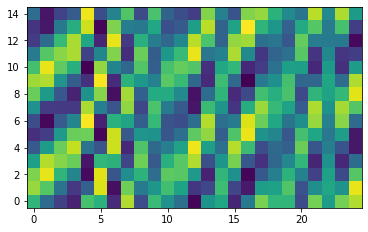

In [0]:
plt.imshow(TorcValues['TORC_448_LIN_10_h501'],origin='lower')
TorcValues['TORC_448_LIN_10_h501'].shape

There it is! But something wrong, it is not very appealing to look at, is it?

Let's talk about what's happening in this plot for a second. Here you are visualizing the spectrogram of the TORC, with the x-axis describing it in time and the y-axis being frequencies. The colored cubes represent the power the sound has at that frequency band at that point in time. I'm *sure* you can now see how that sound we played you earlier totally looks like this, right?



## **Checking out our TORCs *AND* making them look nice!**

Now that you've seen a blurry glimpse of a TORC, let's have some fun while we spruce them up a little too. 

We've got a lot of TORCs we potentially could look at, do we really want to have to run a brick of code each time we want to see a new one, or wouldn't it be *more* fun to make a function that takes any number you give it and shows you that torc?

Take a look at what we've given below. We've defined `plot_torc` as taking two arguments, which will be our dictionary `TorcValues` which contains all of our arrays that are the TORCs paired with the name of the TORC. There is also a number, which will specify which TORC (out of the available 30) you would like to visualize. Next, we've defined a few variables for your convenience later.


Let's take a short interlude to talk about `if` statments. You won't be writing any right now but the logic is kind of fun. `if` statements are great to handle things that could break your function. To this end, you may have been snarky and already thought, "they said pass a number out of 30, I'm going to put 31.. hahaha." **If** you thought that, an `if` statement is going to save the day. 

Notice in the first `if` we say if the inputted number is greater than the number of items in TorcValues (or zero because that TORC doesn't exist either) you'll get kicked out of the function (return) and the result will be an error message. Took care of that problem!

See if you can imagine what the next `if` is for.

Next, we want the TORC to be less pixelated, that's not nice to look at. That line just calls a little function that interpolates the data given, which means it estimates additional data points to give the data a smoother look. Imagine a sine wave that has 5 points versus 100 points, which is smoother?

Anyway, your job now is to use `imshow()` to show us `torcplot`. Take a look at additional arguments that `imshow()` takes, you're going to want to, as above, use the `origin` argument, as well as set the `aspect` argument equal to `auto`.

Now add some labels. The x-axis is displaying time and the y-axis frequency in Hz. But there's a problem with that, you have to tell it to display your frequency labels on the yticks, for this call `plt.yticks()` and check out what arguments it takes. This is where you will want to call your variables earlier in the function `ticks` and `labels`.

Finally, set a title. What would you want to display as a title? Maybe just TORC? But what if you wanted to label it with the specific TORC name you're looking at, do you already have a variable defined in the function that is a TORC name string? (you do!)

### **Exercise**


In [0]:
def plot_torc(torcs,number):
    smooth = [100,250]
    ticks = list([0,20,40,60,80,100])
    labels = list([250,500,1000,2000,4000,8000])
    if number > len(TorcValues) or number == 0:
        print("That's not a real TORC!")
        return
    if number < 10:
        torc = 'TORC_448_LIN_0{}_h501'.format(number)
    else:
        torc = 'TORC_448_LIN_{}_h501'.format(number)
    torcplot = interpft(interpft(torcs[torc], smooth[0], 0), smooth[1], 1)
#Answer
    <plt.imshow(torcplot,aspect='auto',origin='lower')
    plt.yticks(ticks=ticks,labels=labels)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time')
    plt.title(torc,fontweight='bold')>

Time to test it! Call your function, passing `TorcValues` as the first argument and a number of your choosing as the second. Do this a few times with different numbers and see what you get!

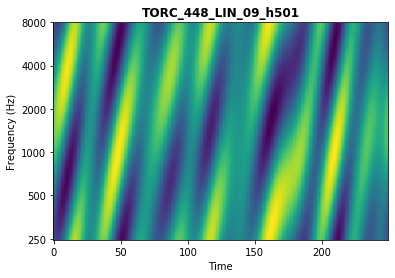

In [0]:
plot_torc(TorcValues,9)

## **Fun's over - back to arrays**

Alright, fun's over. The cell below you're just going to run, but it contains a particularly fun `for` loop variant that has three variables because we're using `enumerate()` and `.items()` to give us both the key and value from our dictionary.

The gist of what is happening here is the same way we wanted a single array with all our response data, we want that for our TORCs. As part of the analysis, we need to `np.roll()` them out, which is basically just to say we're taking the TORC you saw above and shifting it one time bin to the left with each iteration then sticking that onto the bottom of the TORC for all 25 time bins, ending you up with a (375,25) TORC. We're doing that for all the TORCs and lining them up next to each other, left to right, 1-30, giving a new array of (375,750).

When you run the code at the bottom we included code that will simply plot and tell you the shape of the array that contains the stimulus data, just so you believe us that what we told you happened actually happened.

(375, 750)

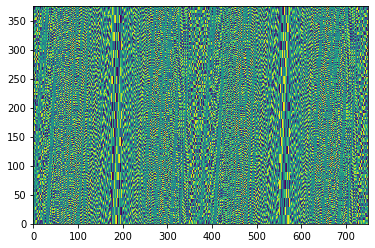

In [0]:
ScaledTorcs = scale_torcs(TorcValues,Params)
DelayTorcs = dict()
for tt, (key, value) in enumerate(ScaledTorcs.items()):
    for jj in range(value.shape[1]):
        rolledtor = np.roll(value, (jj), axis=1)
        if jj == 0:
            torcdel = rolledtor
        else:
            torcdel = np.concatenate((torcdel, rolledtor), axis=0)
    DelayTorcs[key] = torcdel
    if tt == 0:
        stimulus = torcdel
    else:
        stimulus = np.concatenate((stimulus, torcdel), axis=1)
plt.imshow(stimulus,aspect='auto',origin='lower')
stimulus.shape

Great, so our stimulus looks like a poster you could buy at Spencer's when you were a teenager!

Now run the code below and allow some `magic` to occur which will put our response data in a nice uni-dimensional format.

In [0]:
Params['binsize'] = int(basep/TorcValues['TORC_448_LIN_10_h501'].shape[1])
response = response_compiler(stacked,Params)
response.shape

(750,)

## **Calculating the STRF**

Now that we have stimulus and response data, we can use linear algebra to calculate the STRF, which will model how we got from stimulus to response and tell us a little bit about how the neuron recorded from encodes sound.

The basic formula here is `strf = response*inverse of stimulus*inverse of correlation matrix`, or in the terms below `STRF = Y*XT*Cinv`

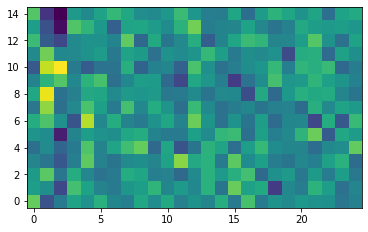

In [0]:
X = stimulus
XT = np.swapaxes(stimulus, 0, 1)
Y = np.swapaxes(np.expand_dims(response, axis=1), 0, 1)
C = np.dot(X, XT)
Cinv = np.linalg.pinv(C)
STRF = np.reshape((np.dot(np.dot(Y, XT), Cinv)), (15, 25), order='F')
STRF.shape
plt.imshow(STRF,origin='lower')

This is the STRF, so we did it! But like the TORCs earlier, this isn't super visually appealing to look at, let's smooth it up and add some labels like before. We'll talk about some of the other fun happening in the upper part of the portion.

In [0]:
def strfplot(strf,Params,smooth=0):
    ylabels = []
    freq = Params['lfreq']
    for fff in range(Params['octaves']):
        if fff != 0:
            freq = freq * 2
        ylabels.append(freq)
    ticks = list([0,20,40,60,80])
    if smooth:
        smooth = [100, 250]
        strfdata = interpft(interpft(strf,smooth[0], 0), smooth[1], 1)
    else:
        strfdata = strf
        ticks = list([0,2,4,6,8,10,12,14])
        ylabels = list([])
    bf = best_frequency(strf,Params)
  # Answer
    <plt.imshow(strfdata,aspect='auto',origin='lower')
    plt.xlabel('Time Lag (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.yticks(ticks=ticks,labels=ylabels)
    plt.title('STRF - Best Frequency: {}'.format(bf), fontweight='bold')>

Run it!

Also, notice that new argument `smooth`, by default above we set it to zero, but down here it is 1, what's happening here? Try running the function with both a 0 then a 1 and see what is different. This is a cool way to use `if` statements too!

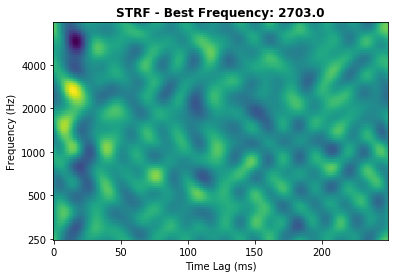

In [0]:
strfplot(STRF,Params,smooth=1)

woot.